<a href="https://colab.research.google.com/github/spindouken/AlzheimersDeepLearning/blob/main/MRIALZ_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install wandb

In [ ]:
import os
import numpy as np
import cv2

def load_and_preprocess_mri(data_directory):
    class_folders = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
    images = []

    for folder in class_folders:
        folder_path = os.path.join(data_directory, folder)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = (img - 127.5) / 127.5  # Normalizing the pixel values
                images.append(img)

    return np.array(images).reshape(-1, 128, 128, 1)


In [ ]:
config = {
    'experiment': {
        'experiment_type': 'baseline',
        'log_directory': '/content/drive/MyDrive/MRIALZ_DCGAN/logs/'
    },
    'hyperparameters': {
        'batch_size': 64,
        'epochs': 80,
        'noise_dim': 100,
        'buffer_size': 6400,
        'generator_learningRate': 0.00004,
        'discriminator_learningRate': 0.00004,
        'generatorOptimizer': 'Adam',
        'discriminatorOptimizer': 'Adam',
        'patience': 80
    },
    'data': {
        'buffer_size': 6400,
        'auto_tune_buffer': True
    },
    'logging': {
        'image_save_interval': 1
    },
    'settings': {
        'use_wandb': True,
        'IMGExampleCount': 4
    }
}


Baseline

In [ ]:
#!/usr/bin/env python3
from tensorflow.keras import layers
import tensorflow as tf

# why does the filter count decrease with each layer in GAN?
# imagine you're painting a picture, you start with a rough sketch of broad strokes and general shapes (high-level features),
#   then you add more and more detail and refine the picture (low-level features), however you don't need as many strokes to add detail
# each higher resolution layer adds finer details, and you might not need as many feature maps as in the lower
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 512)),

        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')  # Change here
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model



Expanded Architecture

In [ ]:
#!/usr/bin/env python3
from tensorflow.keras import layers, Model
import tensorflow as tf

def residual_block(x, filters, kernel_size=3, stride=1, activation="leakyrelu"):
    shortcut = x
    x = layers.Conv2DTranspose(filters, kernel_size=kernel_size, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if activation == "leakyrelu":
        x = layers.LeakyReLU()(x)
    else:
        x = layers.Activation(activation)(x)

    x = layers.Conv2DTranspose(filters, kernel_size=kernel_size, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([shortcut, x])
    return x

def build_generator():
    input_tensor = layers.Input(shape=(100,))

    x = layers.Dense(8*8*512, use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((8, 8, 512))(x)

    x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = residual_block(x, 256)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = residual_block(x, 128)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = residual_block(x, 64)

    output_tensor = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    model = Model(input_tensor, output_tensor)
    return model

def build_discriminator():
    input_tensor = layers.Input(shape=[128, 128, 1])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_tensor)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    output_tensor = layers.Dense(1)(x)

    model = Model(input_tensor, output_tensor)
    return model


In [ ]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
import os
import numpy as np
import yaml
from datetime import datetime
import pytz


USE_WANDB = config["settings"]["use_wandb"]
IMGExampleCount = config["settings"]["IMGExampleCount"]
experiment_type = config["experiment"]["experiment_type"]


os.makedirs("/content/drive/MyDrive/MRIALZ_DCGAN/images", exist_ok=True)

# timestamp stuff
central = pytz.timezone('America/Chicago')
utc_now = datetime.now(pytz.utc)
dt = utc_now.astimezone(central)
timestamp = dt.strftime('%Y-%m-%d_%H-%M-%S')

# images will be saved in folders according to time of run
folder_name = f"{experiment_type}_{timestamp}"
image_save_path = f"/content/drive/MyDrive/MRIALZ_DCGAN/images/{folder_name}/"

if not os.path.exists(image_save_path):
    os.makedirs(image_save_path)


def generateTrainingImages(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0

    grid_size = int(np.sqrt(IMGExampleCount))
    fig = plt.figure(figsize=(grid_size * 2, grid_size * 2))

    for i in range(IMGExampleCount):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    file_name = f"image_at_epoch_{epoch:04d}.png"
    file_path = os.path.join(image_save_path, file_name)

    plt.savefig(f"{image_save_path}image_at_epoch_{epoch:04d}.png")
    plt.close(fig)

    if USE_WANDB:
        import wandb
        wandb.log({"Generated Images": [wandb.Image(file_path)]})


In [ ]:
#!/usr/bin/env python3
import tensorflow as tf
from tqdm import tqdm
import pytz
import os
import yaml
import logging


BATCH_SIZE = config['hyperparameters']['batch_size']
EPOCHS = config['hyperparameters']['epochs']
NOISE_DIM = config['hyperparameters']['noise_dim']
BUFFER_SIZE = config['data']['buffer_size']
USE_WANDB = config['settings']['use_wandb']
IMGExampleCount = config['settings']['IMGExampleCount']
IMAGE_SAVE_INTERVAL = config['logging']['image_save_interval']


log_directory = config['experiment']['log_directory']
if not os.path.exists(log_directory):
    os.makedirs(log_directory)
logging.basicConfig(
    filename=os.path.join(log_directory, 'training.log'),
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] - %(message)s',  # This will include the timestamp
    datefmt='%Y-%m-%d %H:%M:%S'  # Format of the timestamp
)


generator_learningRate = config['hyperparameters']['generator_learningRate']
discriminator_learningRate = config['hyperparameters']['discriminator_learningRate']
generator_optimizer = getattr(tf.keras.optimizers, config['hyperparameters']['generatorOptimizer'])(generator_learningRate)
discriminator_optimizer = getattr(tf.keras.optimizers, config['hyperparameters']['discriminatorOptimizer'])(discriminator_learningRate)
patience = config['hyperparameters']['patience']
patience_counter = 0
experiment_type = config['experiment']['experiment_type']


if USE_WANDB:
    import wandb
    wandb.init(project='mrialz_dcgan', name=f'dcgan_run_{experiment_type}', config=config)

train_images = load_and_preprocess_mri('/content/drive/MyDrive/MRIALZ_DCGAN/Dataset')
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

generator = build_generator()
discriminator = build_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def train_step(images, step):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, 0.5), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, 0.5), tf.float32))
    disc_accuracy = (real_accuracy + fake_accuracy) / 2.0
    gen_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(fake_output, 0.5), tf.float32))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, gen_accuracy, disc_accuracy

test_input = tf.random.normal([IMGExampleCount, NOISE_DIM])
# to track loss and accuracy
cumulative_gen_loss = 0.0
cumulative_disc_loss = 0.0
cumulative_gen_accuracy = 0.0
cumulative_disc_accuracy = 0.0
num_steps = 0

pbar = tqdm(range(EPOCHS))

# early stopping
best_loss = float('inf')
patience_counter = 0

for epoch in pbar:
    cumulative_gen_loss = 0.0
    cumulative_disc_loss = 0.0
    cumulative_gen_accuracy = 0.0
    cumulative_disc_accuracy = 0.0
    num_steps = 0

    for step, image_batch in enumerate(train_dataset):
        # training
        gen_loss, disc_loss, gen_acc, disc_acc = train_step(image_batch, step)
        cumulative_gen_loss += gen_loss
        cumulative_disc_loss += disc_loss
        cumulative_gen_accuracy += gen_acc
        cumulative_disc_accuracy += disc_acc
        num_steps += 1

        # log metrics for this batch
        if USE_WANDB:
            wandb.log({"batch_gen_loss": gen_loss.numpy(),
                    "batch_disc_loss": disc_loss.numpy(),
                    "batch_gen_accuracy": gen_acc.numpy(),
                    "batch_disc_accuracy": disc_acc.numpy()})

    avg_gen_loss = cumulative_gen_loss / num_steps
    avg_disc_loss = cumulative_disc_loss / num_steps
    avg_gen_accuracy = cumulative_gen_accuracy / num_steps
    avg_disc_accuracy = cumulative_disc_accuracy / num_steps

    # early stopping
    if avg_gen_loss < best_loss:
        best_loss = avg_gen_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter > patience:
            logging.info("Early stopping triggered.")
            print("Early stopping triggered. Training has been halted.")
            break



    logging.info(f"Experiment Type: {experiment_type}, Epoch {epoch+1}, Avg Gen Loss: {avg_gen_loss}, Avg Disc Loss: {avg_disc_loss}")

    # log metrics for the epoch on wandb
    if USE_WANDB:
        wandb.log({"epoch": epoch, "avg_gen_loss": avg_gen_loss, "avg_disc_loss": avg_disc_loss, "avg_gen_accuracy": avg_gen_accuracy, "avg_disc_accuracy": avg_disc_accuracy, "experiment_type": experiment_type})
    else:
        print(f"Epoch {epoch+1}, Avg Gen Loss: {avg_gen_loss}, Avg Disc Loss: {avg_disc_loss}, Avg Gen Accuracy: {avg_gen_accuracy}, Avg Disc Accuracy: {avg_disc_accuracy}")

    if epoch % IMAGE_SAVE_INTERVAL == 0:
        generateTrainingImages(generator, epoch, test_input)

    pbar.set_description(f"Epoch {epoch+1}, Avg Gen Loss: {avg_gen_loss}, Avg Disc Loss: {avg_disc_loss}")


avg_disc_accuracy,█▅▄▂▃▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁
avg_disc_loss,▁▅▅█▆▇█▇█▇▇▇▇██▇█▇█▇
avg_gen_accuracy,▂▆▆█▃▄▅▂▂▂▂▂▂▃▂▁▁▁▁▁
avg_gen_loss,█▄▄▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_disc_accuracy,██▄▆▇▃▅▁▄▄▃▂▂▂▃▃▂▂▂▂▂▂▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂
batch_disc_loss,▃▁▅▄▃▆▅█▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▅▆▆▆▆▇▆▆▆▆▆▆▆▆▆▆
batch_gen_accuracy,▁▁▃▂▁▃▃█▁▁▁▆▅▄▂▁▄▂▂▂▂▁▁▂▁▁▁▃▁▃▁▁▁▁▁▁▁▁▁▁
batch_gen_loss,▁█▄▃▆▃▃▁▄▃▅▁▁▂▂▂▁▂▂▂▃▂▂▂▃▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
avg_disc_accuracy,0.50187
avg_disc_loss,1.36961


Epoch 80, Avg Gen Loss: 0.9114328026771545, Avg Disc Loss: 1.2007943391799927: 100%|██████████| 80/80 [33:24<00:00, 25.05s/it]


In [ ]:
import time
from IPython import display
from PIL import Image
import glob

image_path = '/content/drive/MyDrive/MRIALZ_DCGAN/images/20epochbaseline/'

image_list = sorted(glob.glob(f"{image_path}/*.png"))

for image_filename in image_list:
    display.display(Image.open(image_filename))
    time.sleep(.4)  # show each image for 1 second
    display.clear_output(wait=True)


In [ ]:
import time
from IPython import display
from PIL import Image
import glob

image_path = '/content/drive/MyDrive/MRIALZ_DCGAN/images/residualBlocks1stRun/'

image_list = sorted(glob.glob(f"{image_path}/*.png"))

for image_filename in image_list:
    display.display(Image.open(image_filename))
    time.sleep(.4)  # show each image for 1 second
    display.clear_output(wait=True)


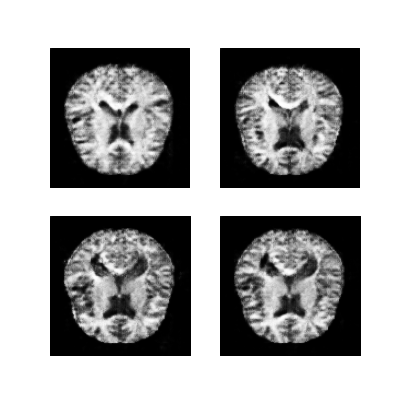

In [ ]:
import time
from IPython import display
from PIL import Image
import glob

image_path = '/content/drive/MyDrive/MRIALZ_DCGAN/images/baseline_2023-11-02_01-42-38/'

image_list = sorted(glob.glob(f"{image_path}/*.png"))

for image_filename in image_list:
    display.display(Image.open(image_filename))
    time.sleep(.4)  # show each image for 1 second
    display.clear_output(wait=True)